# Trabalho Prático 3

Grupo 22:
    
    João Marques A84684

In [1]:
!pip install z3-solver
from z3 import*


**Problema**


> O objetivo deste trabalho é o uso de SMT’s para modelar e verificar propriedades lógicas de sistemas dinâmicos. O trabalho pode ser executado em Z3 , como o seu “wrapper” específico, ou desejavelmente com o “wrapper” PySMT , usando  Z3 e MatSAT e comparando os resultados.


No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


4. Faça
    1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
    2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
        2. “a velocidade $V$ diminui sempre com o tempo”.
    3. Codifique em SMT’s o modelo que definiu em a.
    4. Codifique a verificação das propriedades temporais que definiu em b.

Equações de Fluxo 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.


5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,
    
    $\begin{array}{rcl} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$  

    e , no modo `Blocked`,  a dinâmica do sistema é  regida por
        $(V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,)$



6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$ segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

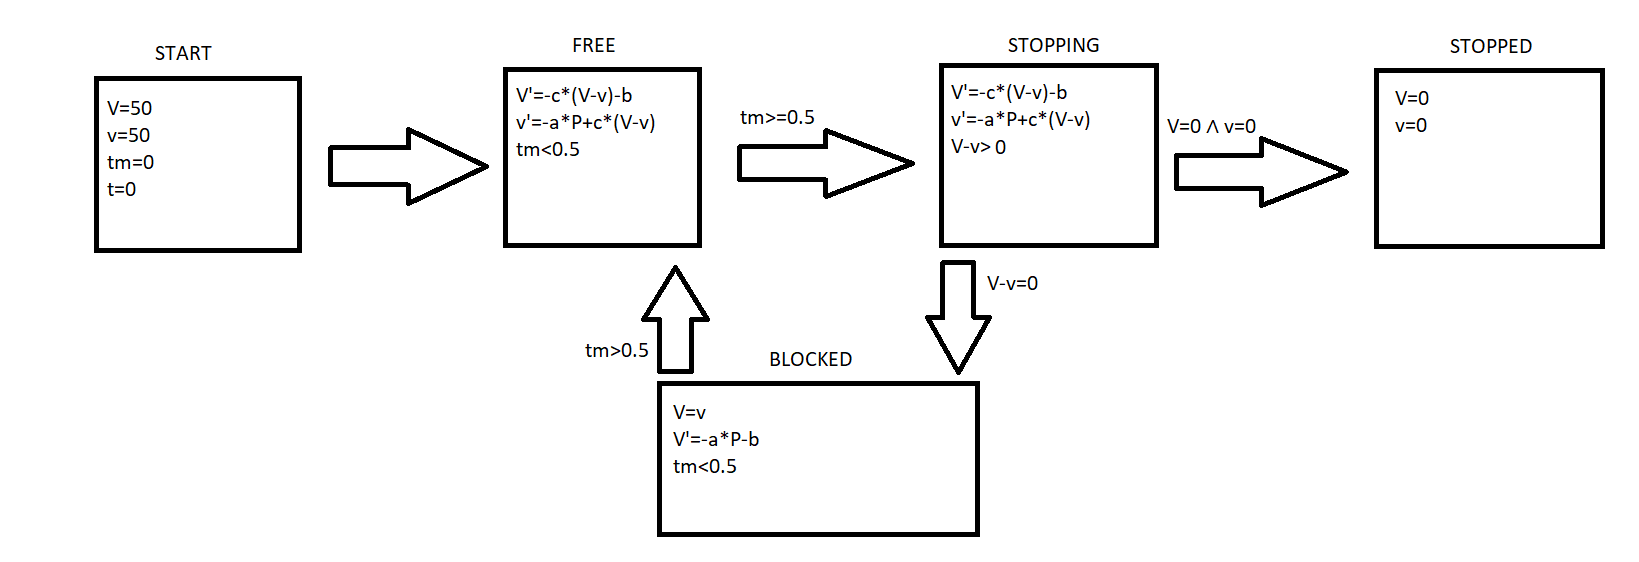

#### Verificação do HA com FOTS

O estado inicial do FOTS é derivado facilmente:
    
$m=START \land V=V0 \land v=v0 \land t=0 \land tm=0$

##### Transições Untimed

$m = START \land m'=FREE \land V=V' \land v=v' \land t'=t \land tm'=0$

$\lor$

$m = FREE \land m'=STOPPING \land V=V' \land v=v' \land t = t' \land tm \ge 0.5$

$\lor$

$m=STOPPING \land m'=BLOCKED \land V=V' \land v=v' \land V-v=0 \land t=t' \land tm'=0$

$\lor$

$m=STOPPING \land m' = STOPPED \land V=V' \land v=v' \land V=0 \land v=0 \land t=t' \land tm=tm'$

$\lor$

$m=BLOCKED \land m'=FREE \land V'=V \land v'=v \land t=t' \land tm\ge 0.5 \land tm'=0$

$\lor$

$m=STOPPED \land m' = STOPPED \land V=V' \land v=v' \land t=t' \land tm=tm'$


##### Transições Timed

$m=FREE \land m'=FREE \land t'=t+0.05 \land tm<0.5 \land tm' = tm + 0.05 \land V'= V + (-c*(V-v)-b) * 0.05 \land v'=v + (-a*P+c*(V-v))*0.05$

$m=BLOCKED \land m'=BLOCKED \land tm<0.5 \land tm' = tm + 0.05 \land t'=t+0.05 \land V'=V+(-a*P-b)*0.05 \land v'=V'$

$m=STOPPING \land m'=STOPPING \land V\ge 0 \land v\ge 0 \land V-v \ge 0 \land tm'=tm \land t'=t+0.05 \land V'=V+(-c*(V-v)-b)*0.05 \land v'=v+(-a*P+c*(V-v))*0.05$


#### Variáveis

##### Constantes:
* $a$ -> constante do atrito
* $P$ -> peso
* $V$ -> velocidade do corpo
* $v$ -> velocidade linear das rodas
* $b$ -> atrito no contacto corpo/ar
* $c$ -> constante de proporcionalidade 

##### Contínuas
* $T$ -> tempo em segundos
* $tm$ -> timer usado nos modos FREE e BLOCKED

##### Discretas
* $m$ -> modo

#### Lógica temporal linear (LTL)

1. "o veículo imobiliza-se completamente em menos de t segundos"

    $T \ge t \implies m=STOPPED $


2. "a velocidade V diminui sempre com o tempo"

    $T'>T \implies V'<V$

#### Código

In [2]:
# Declaração de modos
Mode, (Start,Free,Stopping,Blocked,Stopped) = EnumSort('Mode', ('Start','Free','Stopping','Blocked','Stopped'))

# valores constantes
a = 0.01
P = 1000
v_init = 50
b = 0.5
c = 0.5
sc = 7
tau=0.5
vt=0.05

# Declarar variáveis
def var(i):
    v = {}
    v['m'] = Const('m'+str(i),Mode) 
    v['V'] = Real('V'+str(i))
    v['v'] = Real('v'+str(i))
    v['t'] = Real('t'+str(i))
    v['tm'] = Real('tm'+str(i))
    return v

# START
def start(s):
    return And(s['m'] == Start, s['V'] == v_init, s['v'] == v_init, s['t'] == 0, s['tm'] == 0)

# Transições
def trans(s,p):
    #untimed
    startToFree = And(s['m']==Start, p['m']==Free, s['V']==p['V'], s['v']==p['v'], s['t']==p['t'], s['tm']==p['tm'])
    
    freeToStopping = And(s['m']==Free, p['m']==Stopping, s['V']==p['V'], s['v']==p['v'], s['t']==p['t'], s['tm']>=0.5)

    stoppingToBlocked = And(s['m']==Stopping, p['m']==Blocked, s['V']==p['V'], s['v']==p['v'], s['t']==p['t'], p['tm']==0, s['V']-s['v']==0)

    blockedtoFree = And(s['m']==Blocked, p['m']==Free, s['V']==p['V'], s['v']==p['v'], s['t']==p['t'], s['tm']>=0.5, p['tm']==0)

    stoppingToStopped = And(s['m']==Stopping, p['m']==Stopped, s['V']==p['V'], s['v']==p['v'], s['V']==0, s['v']==0, s['t']==p['t'], s['tm']==s['tm'])

    stoppedToStopped = And(s['m']==Stopped, p['m']==Stopped, s['V']==p['V'], s['v']==p['v'], s['t']==p['t'], s['tm']==p['tm'])

    #timed
    freeToFree = And(s['m']==Free, p['m']==Free, p['t']==s['t']+vt, s['tm']<0.5, p['tm']==s['tm']+vt, p['V'] == s['V']+(-c*(s['V']-s['v'])-b)*vt, p['v'] == s['v'] + (-a*P+c*(s['V']-s['v']))*vt)

    blockedToBlocked = And(s['m']==Blocked, p['m']==Blocked, s['tm']<0.5, p['tm']==s['tm']+vt, p['t']==s['t']+vt, p['V']==s['V']+(-a*P-b)*vt, p['v']==p['V'])

    stoppingToStopping = And(s['m']==Stopping, p['m']==Stopping,s['V']>0,s['v']>0, s['V']-s['v']>0, s['tm']==p['tm'], p['t']==s['t']+vt, p['V']==s['V']+(-sc*(s['V']-s['v'])-b)*vt, p['v']==s['v'] + (-a*P+sc*(s['V']-s['v']))*vt)

    return Or(startToFree, freeToStopping, stoppingToBlocked, blockedtoFree, stoppingToStopped, stoppedToStopped, freeToFree, 
    blockedToBlocked, stoppingToStopping)


#### Traço de Execução

Através do Z3-solver, vamo agora gerar uma função que vai simular um sistema com $K$ estados

In [3]:
def traco(var, start, trans , k):
    s = Solver()
    tr = [var(i) for i in range(k)]

    s.add(start(tr[0]))
    
    
    for i in range(k-1):
        s.add(trans(tr[i],tr[i+1]))
    
    status = s.check()

    if status==sat:
        m = s.model()
        for i in range(k):
            print("Estado: ", i)
            for v in tr[i]:
                n = m[tr[i][v]]
                if n.sort() != RealSort():
                    print(v,'=', n)
                else:
                    print(v, '=', float(n.numerator_as_long())/float(n.denominator_as_long()))
        
    elif status == unsat:
        print("Impossivel")
    else:
        print("Unkown")


In [4]:
traco(var,start,trans,10)

Estado:  0
m = Start
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  1
m = Free
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  2
m = Free
V = 49.975
v = 49.5
t = 0.05
tm = 0.05
Estado:  3
m = Free
V = 49.938125
v = 49.011875
t = 0.1
tm = 0.1
Estado:  4
m = Free
V = 49.88996875
v = 48.53503125
t = 0.15
tm = 0.15
Estado:  5
m = Free
V = 49.8310953125
v = 48.0689046875
t = 0.2
tm = 0.2
Estado:  6
m = Free
V = 49.762040546875
v = 47.612959453125
t = 0.25
tm = 0.25
Estado:  7
m = Free
V = 49.68331351953125
v = 47.16668648046875
t = 0.3
tm = 0.3
Estado:  8
m = Free
V = 49.595397843554686
v = 46.72960215644531
t = 0.35
tm = 0.35
Estado:  9
m = Free
V = 49.49875295137695
v = 46.30124704862305
t = 0.4
tm = 0.4


In [5]:
traco(var,start,trans,25)

Estado:  0
m = Start
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  1
m = Free
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  2
m = Free
V = 49.975
v = 49.5
t = 0.05
tm = 0.05
Estado:  3
m = Free
V = 49.938125
v = 49.011875
t = 0.1
tm = 0.1
Estado:  4
m = Free
V = 49.88996875
v = 48.53503125
t = 0.15
tm = 0.15
Estado:  5
m = Free
V = 49.8310953125
v = 48.0689046875
t = 0.2
tm = 0.2
Estado:  6
m = Free
V = 49.762040546875
v = 47.612959453125
t = 0.25
tm = 0.25
Estado:  7
m = Free
V = 49.68331351953125
v = 47.16668648046875
t = 0.3
tm = 0.3
Estado:  8
m = Free
V = 49.595397843554686
v = 46.72960215644531
t = 0.35
tm = 0.35
Estado:  9
m = Free
V = 49.49875295137695
v = 46.30124704862305
t = 0.4
tm = 0.4
Estado:  10
m = Free
V = 49.393815303808104
v = 45.881184696191895
t = 0.45
tm = 0.45
Estado:  11
m = Free
V = 49.2809995386177
v = 45.4690004613823
t = 0.5
tm = 0.5
Estado:  12
m = Stopping
V = 49.2809995386177
v = 45.4690004613823
t = 0.5
tm = 2.0
Estado:  13
m = Stopping
V = 47.92179986158531

In [6]:
traco(var,start,trans,34)

Estado:  0
m = Start
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  1
m = Free
V = 50.0
v = 50.0
t = 0.0
tm = 0.0
Estado:  2
m = Free
V = 49.975
v = 49.5
t = 0.05
tm = 0.05
Estado:  3
m = Free
V = 49.938125
v = 49.011875
t = 0.1
tm = 0.1
Estado:  4
m = Free
V = 49.88996875
v = 48.53503125
t = 0.15
tm = 0.15
Estado:  5
m = Free
V = 49.8310953125
v = 48.0689046875
t = 0.2
tm = 0.2
Estado:  6
m = Free
V = 49.762040546875
v = 47.612959453125
t = 0.25
tm = 0.25
Estado:  7
m = Free
V = 49.68331351953125
v = 47.16668648046875
t = 0.3
tm = 0.3
Estado:  8
m = Free
V = 49.595397843554686
v = 46.72960215644531
t = 0.35
tm = 0.35
Estado:  9
m = Free
V = 49.49875295137695
v = 46.30124704862305
t = 0.4
tm = 0.4
Estado:  10
m = Free
V = 49.393815303808104
v = 45.881184696191895
t = 0.45
tm = 0.45
Estado:  11
m = Free
V = 49.2809995386177
v = 45.4690004613823
t = 0.5
tm = 0.5
Estado:  12
m = Stopping
V = 49.2809995386177
v = 45.4690004613823
t = 0.5
tm = 0.13124970858441348
Estado:  13
m = Stopping
V = 4